In [3]:
import sys
from math import pi,sin, sqrt
import numpy 
import matplotlib.pyplot as plt
# import h5py
import os
import glob
import meshio
# import pyvista
import numpy as np
from matplotlib.cm import get_cmap

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.labelweight"] = "regular"
font1 = {'size': 18, 'weight': 'regular', 'color':  'black'}

/tmp/ipykernel_1734065/2796876379.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('terrain')


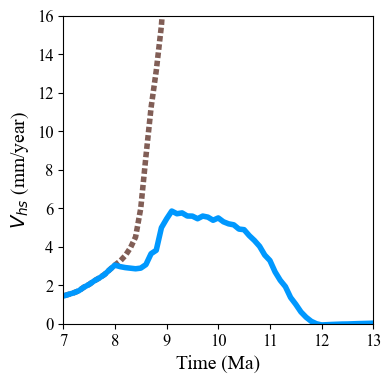

In [5]:

cmap = get_cmap('terrain')
# Constants
mpi = 16
max_time_steps_cf = 126  # Total number of time steps for CF model
max_time_steps_tdm = 200  # Total number of time steps for TDM model
time_step_to_m_years = 0.1  # Convert time steps to millions of years
target_T = 273  # Target temperature for filtering
x_threshold = 500000  # Threshold for x_i_cf

# Paths for the datasets
path_cf = '/home/chameera/CERI/Fall2024/new_BC/ct_01/solution/solution-%s.%s.vtu'
path_tdm = '/home/chameera/CERI/Fall2024/new_BC/tdm_120mpa_over_4ma_at_8ma/solution/solution-%s.%s.vtu'

# Initialize arrays to store results
mean_velocity_cf = []  # Mean velocity for path_cf
mean_velocity_tdm = []  # Mean velocity for path_tdm

# Function to calculate mean velocity for a given path
def calculate_mean_velocity(path, mpi, max_time_steps, target_T, x_threshold):
    mean_velocity = []
    for k in range(max_time_steps):
        T_i = []
        x_i = []
        velocity_x = []

        for i in range(mpi):
            file_path = path % (str(k).rjust(5, "0"), str(i).rjust(4, "0"))
            result = meshio.read(file_path)
            x_i = np.append(x_i, result.points[:, 0])
            T_i = np.append(T_i, result.point_data['T'])
            velocity_x = np.append(velocity_x, result.point_data['velocity'][:, 0])  # Extract x-component

        # Filter for T_i == target_T and x_i > x_threshold
        mask = (T_i == target_T) & (x_i >= x_threshold)
        filtered_velocity_x = velocity_x[mask]

        # Calculate mean velocity (convert to mm/year)
        if len(filtered_velocity_x) > 0:
            mean_velocity.append(np.mean(filtered_velocity_x) * 1000)  # Convert m/year to mm/year
        else:
            mean_velocity.append(np.nan)  # Append NaN if no valid data

    return mean_velocity

# Perform calculations for both paths
mean_velocity_cf = calculate_mean_velocity(path_cf, mpi, max_time_steps_cf, target_T, x_threshold)
mean_velocity_tdm = calculate_mean_velocity(path_tdm, mpi, max_time_steps_tdm, target_T, x_threshold)

# Generate the M_years arrays (in millions of years)
M_years_cf = np.arange(max_time_steps_cf) * time_step_to_m_years
M_years_tdm = np.arange(max_time_steps_tdm) * time_step_to_m_years

# Plotting the results
plt.figure(figsize=(4, 4))
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.plot(M_years_cf, mean_velocity_cf,linewidth=4.0, linestyle="dashed",dashes=(1, 0.5), color=cmap(0.75), label='CFM')
plt.plot(M_years_tdm, mean_velocity_tdm,linewidth=4.0, linestyle='-', color=cmap(0.15), label='Model22')
plt.xlabel('Time (Ma)',fontsize=14)
plt.ylabel('$V_{hs}$ (mm/year)',fontsize=14)
#plt.title('$V_{hs}$')
#plt.grid(True)
plt.ylim([0,16])
plt.xlim([7,13])
#plt.legend(fontsize=12,loc='upper right',framealpha=0.01,bbox_to_anchor=(1.03, 0.95))
plt.show()
